# Steps:
1) preprocessing
2) splitting
3) tokenize & padding
4) Create model & train
5) evaluate

# Preprocessing (cleaning the datasets):

1) remove html entity
2) change user tags (@xxx -> user)
3) remove urls
4) remove unnecessary symbol ('', !, ", ') -> cause a lot of noise in the dataset
5) remove stopwords

# 1| Import libraries

In [16]:
import pandas as pd # read the csv
import re # regex to detect username, url, html entity 
import nltk # to use word tokenize (split the sentence into words)
from nltk.corpus import stopwords # to remove the stopwords
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

from keras.utils import to_categorical
from keras import backend as K
import zipfile
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\NOCAY\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\NOCAY\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

# 2| read the data

In [4]:
zipfile_name = 'train.csv.zip'
with zipfile.ZipFile(zipfile_name, 'r') as file:
 file.extractall()

In [5]:
data = pd.read_csv("train.csv")

data.head()

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [8]:
# dataset shape to know how many tweets in the datasets
print(f"num of tweets: {data.shape}")

# extract the text and labels
tweet = list(data['tweet'])
labels = list(data['class'])

num of tweets: (24783, 6)


# 3| functions to clean the data

In [ ]:
#import nltk
#nltk.download('stopwords')

In [14]:
#notes : all of the function taking 1 text at a time
stop_words = set(stopwords.words('english'))
# add rt to remove retweet in dataset (noise)
stop_words.add("rt")

# remove html entity:
def remove_entity(raw_text):
    entity_regex = r"&[^\s;]+;"
    text = re.sub(entity_regex, "", raw_text)
    return text

# change the user tags
def change_user(raw_text):
    regex = r"@([^ ]+)"
    text = re.sub(regex, "user", raw_text)

    return text

# remove urls
def remove_url(raw_text):
    url_regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    text = re.sub(url_regex, '', raw_text)

    return text

# remove unnecessary symbols
def remove_noise_symbols(raw_text):
    text = raw_text.replace('"', '')
    text = text.replace("'", '')
    text = text.replace("!", '')
    text = text.replace("`", '')
    text = text.replace("..", '')

    return text

# remove stopwords
def remove_stopwords(raw_text):
    tokenize = nltk.word_tokenize(raw_text)
    text = [word for word in tokenize if not word.lower() in stop_words]
    text = " ".join(text)

    return text

## this function in to clean all the dataset by utilizing all the function above
def preprocess(datas):
    clean = []
    # change the @xxx into "user"
    clean = [change_user(text) for text in datas]
    # remove emojis (specifically unicode emojis)
    clean = [remove_entity(text) for text in clean]
    # remove urls
    clean = [remove_url(text) for text in clean]
    # remove trailing stuff
    clean = [remove_noise_symbols(text) for text in clean]
    # remove stopwords
    clean = [remove_stopwords(text) for text in clean]

    return clean

In [ ]:
#import nltk
#nltk.download('punkt')

In [17]:
# call the cleaning function
clean_tweet = preprocess(tweet)

# 4| Splitting the dataset into test and validation

In [18]:
X_train, X_test, y_train, y_test = train_test_split(clean_tweet, labels, test_size=0.2, random_state=42)

In [19]:
## Tokenizing -> basically we use tokenisation for many things, its commonly used for feature extraction in preprocessing. btw idk how it works as feature extraction tho :(
# declare the tokenizer
tokenizer = Tokenizer()
# build the vocabulary based on train dataset
tokenizer.fit_on_texts(X_train)
# tokenize the train and test dataset
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# vocabulary size (num of unique words) -> will be used in embedding layer
vocab_size = len(tokenizer.word_index) + 1

In [20]:
## Padding -> to uniform the datas
max_length = max(len(seq) for seq in X_train)

# to test an outlier case (if one of the test dataset has longer length)
for x in X_test:
    if len(x) > max_length:
        print(f"an outlier detected: {x}")

X_train = pad_sequences(X_train, maxlen = max_length)
X_test = pad_sequences(X_test, maxlen = max_length)

In [21]:
# create hot_labels (idk whty tapi ini penting, kalo ga bakal error)
y_test = to_categorical(y_test, num_classes=3)
y_train = to_categorical(y_train, num_classes=3)

In [22]:
# another look on the number of tweet in test and training data

print(f"num test tweet: {y_test.shape[0]}")
print(f"num train tweet: {y_train.shape[0]}")

num test tweet: 4957
num train tweet: 19826


# 5| Building the model

In [23]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precisions = precision(y_true, y_pred)
    recalls = recall(y_true, y_pred)
    return 2*((precisions*recalls)/(precisions+recalls+K.epsilon()))

In [24]:
# change dis if u want
output_dim = 200

# LSTM model architechture (CNN + LSTM)
model = Sequential([
    # embedding layer is like idk
    Embedding(vocab_size, output_dim, input_length=max_length),
    # lstm for xxx
    LSTM(64, dropout=0.3, recurrent_dropout=0.3),
    # dropout to prevent overfitting
    Dropout(0.5),
    # dense to connect the previous output with current layer
    Dense(128, activation="relu"),
    # dropout to prevent overfitting
    Dropout(0.5),
    # this is output layer, with 3 class (0, 1, 2)
    Dense(3, activation="softmax"),
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',f1,precision, recall])

In [25]:
# checking the model parameters
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 26, 200)           3734200   
                                                                 
 lstm (LSTM)                 (None, 64)                67840     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 3810747 (14.54 MB)
Trainable params: 38107

In [26]:
# Train the model
model_history = model.fit(
    X_train,
    y_train,
    batch_size = 64,
    epochs=10,
    validation_data=(X_test, y_test)
)

Epoch 1/10
310/310 [==============================] - 68s 173ms/step - loss: 0.4599 - accuracy: 0.8422 - f1: 0.8206 - precision: 0.8506 - recall: 0.7968 - val_loss: 0.3228 - val_accuracy: 0.8880 - val_f1: 0.8862 - val_precision: 0.8988 - val_recall: 0.8741
Epoch 2/10
310/310 [==============================] - 51s 165ms/step - loss: 0.2321 - accuracy: 0.9201 - f1: 0.9201 - precision: 0.9306 - recall: 0.9100 - val_loss: 0.3216 - val_accuracy: 0.8840 - val_f1: 0.8844 - val_precision: 0.8948 - val_recall: 0.8745
Epoch 3/10
310/310 [==============================] - 52s 169ms/step - loss: 0.1486 - accuracy: 0.9463 - f1: 0.9470 - precision: 0.9504 - recall: 0.9436 - val_loss: 0.4371 - val_accuracy: 0.8858 - val_f1: 0.8849 - val_precision: 0.8871 - val_recall: 0.8828
Epoch 4/10
310/310 [==============================] - 51s 166ms/step - loss: 0.1037 - accuracy: 0.9629 - f1: 0.9629 - precision: 0.9641 - recall: 0.9616 - val_loss: 0.4610 - val_accuracy: 0.8749 - val_f1: 0.8746 - val_precision: 

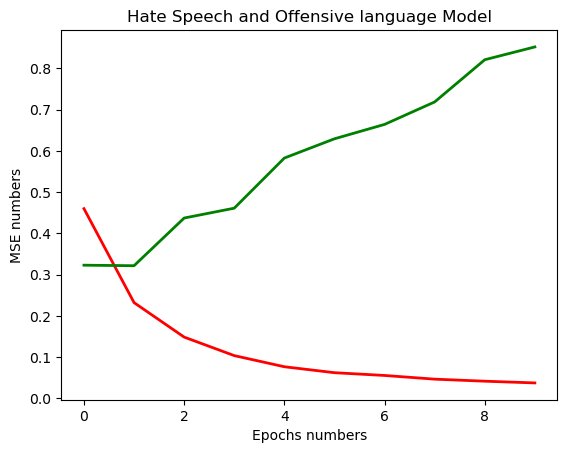

In [27]:
import matplotlib.pyplot as plt
hist = model.history.history
plt.plot(hist['loss'],'r',linewidth=2, label='Training loss')
plt.plot(hist['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('Hate Speech and Offensive language Model')
plt.xlabel('Epochs numbers')
plt.ylabel('MSE numbers')
plt.show()

## Thanks alot upvotes ##